### Reference
1. https://github.com/dmlc/dgl/tree/master/examples/pytorch/NGCF
2. https://arxiv.org/abs/1905.08108

### Gowalla dataset

Gowalla is a location-based social networking website where users share their locations by checking-in. The friendship network is undirected and was collected using their public API, and consists of 196,591 nodes and 950,327 edges. We have collected a total of 6,442,890 check-ins of these users over the period of Feb. 2009 - Oct. 2010.

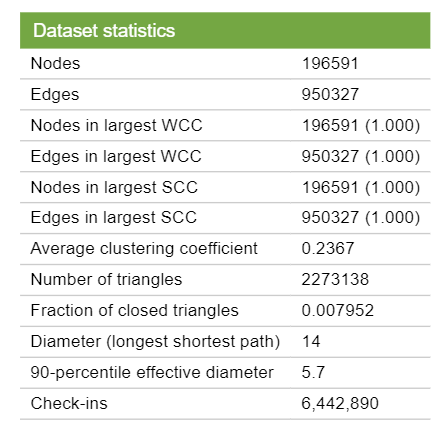

**Source (citation)** - E. Cho, S. A. Myers, J. Leskovec. [Friendship and Mobility: Friendship and Mobility: User Movement in Location-Based Social Networks](http://cs.stanford.edu/people/jure/pubs/mobile-kdd11.pdf) ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2011.

**More Info** - https://snap.stanford.edu/data/loc-gowalla.html

### Loading the dataset

This is a preprocessed dataset. To ensure the quality of the dataset, **10-core setting** is used, i.e., retaining users and items with at least ten interactions.

In [1]:
!wget https://s3.us-west-2.amazonaws.com/dgl-data/dataset/gowalla.zip
!unzip gowalla.zip

--2021-07-19 17:52:34--  https://s3.us-west-2.amazonaws.com/dgl-data/dataset/gowalla.zip
Resolving s3.us-west-2.amazonaws.com (s3.us-west-2.amazonaws.com)... 52.92.148.112
Connecting to s3.us-west-2.amazonaws.com (s3.us-west-2.amazonaws.com)|52.92.148.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2985934 (2.8M) [application/zip]
Saving to: ‘gowalla.zip’

gowalla.zip         100%[===================>]   2.85M  10.7MB/s    in 0.3s    

2021-07-19 17:52:35 (10.7 MB/s) - ‘gowalla.zip’ saved [2985934/2985934]

Archive:  gowalla.zip
   creating: gowalla/
  inflating: gowalla/user_list.txt   
  inflating: gowalla/item_list.txt   
  inflating: gowalla/test.txt        
  inflating: gowalla/README.md       
  inflating: gowalla/train.txt       


In [2]:
!head gowalla/user_list.txt

org_id remap_id
343 0
5258 1
3973 2
5254 3
6686 4
138 5
253 6
254 7
494 8


In [3]:
!head gowalla/item_list.txt

org_id remap_id
8975 0
9190 1
15195 2
23360 3
22944 4
22575 5
18622 6
17107 7
16012 8


> Note: `user_list.txt` and `item_list.txt` are simply label maps.

In [4]:
!head gowalla/train.txt

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
1 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
2 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 160 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
3 259 260 244 243 261 262 263 264 265 266 246 267 268 269 270 27

> Tip: This type of preprocessing can be done using [this](https://nb.recohut.com/graph/pytorch/movie/2021/07/12/ngcf-movielens.html#Preprocessing) code that we used for preprocessing of movielens also, prior to NGCF training.

In [12]:
!nvidia-smi

Mon Jul 19 18:08:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
!pip install dgl-cu111

In [1]:
import os
import re
import heapq
import argparse
import numpy as np
import random as rd
from time import time
import multiprocessing
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dgl
import dgl.function as fn

Using backend: pytorch


### Utils

In [2]:
def txt2list(file_src):
    orig_file = open(file_src, "r")
    lines = orig_file.readlines()
    return lines

def ensureDir(dir_path):
    d = os.path.dirname(dir_path)
    if not os.path.exists(d):
        os.makedirs(d)

def uni2str(unicode_str):
    return str(unicode_str.encode('ascii', 'ignore')).replace('\n', '').strip()

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

def delMultiChar(inputString, chars):
    for ch in chars:
        inputString = inputString.replace(ch, '')
    return inputString

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def early_stopping(log_value, best_value, stopping_step, expected_order='acc', flag_step=100):
    # early stopping strategy:
    assert expected_order in ['acc', 'dec']

    if (expected_order == 'acc' and log_value >= best_value) or (expected_order == 'dec' and log_value <= best_value):
        stopping_step = 0
        best_value = log_value
    else:
        stopping_step += 1

    if stopping_step >= flag_step:
        print("Early stopping is trigger at step: {} log:{}".format(flag_step, log_value))
        should_stop = True
    else:
        should_stop = False
    return best_value, stopping_step, should_stop

### Metrics

In [3]:
def recall(rank, ground_truth, N):
    return len(set(rank[:N]) & set(ground_truth)) / float(len(set(ground_truth)))


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)


def average_precision(r,cut):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(cut) if r[k]]
    if not out:
        return 0.
    return np.sum(out)/float(min(cut, np.sum(r)))


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def recall_at_k(r, k, all_pos_num):
    r = np.asfarray(r)[:k]
    return np.sum(r) / all_pos_num


def hit_at_k(r, k):
    r = np.array(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.

def auc(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)
    except Exception:
        res = 0.
    return res

### Data loader

In [4]:
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.exist_users = []

        user_item_src = []
        user_item_dst = []

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    self.n_train += len(items)
                    for i in l[1:]:
                        user_item_src.append(uid)
                        user_item_dst.append(int(i))

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    self.n_items = max(self.n_items, max(items))
                    self.n_test += len(items)
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        #training positive items corresponding to each user; testing positive items corresponding to each user
        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0:
                        break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue

                    uid, test_items = items[0], items[1:]
                    self.test_set[uid] = test_items
        
        #construct graph from the train data and add self-loops
        user_selfs = [ i for i in range(self.n_users)]
        item_selfs = [ i for i in range(self.n_items)]
        
        data_dict = {
                ('user', 'user_self', 'user') : (user_selfs, user_selfs),
                ('item', 'item_self', 'item') : (item_selfs, item_selfs),
                ('user', 'ui', 'item') : (user_item_src, user_item_dst),
                ('item', 'iu', 'user') : (user_item_dst, user_item_src)
                }
        num_dict = {
            'user': self.n_users, 'item': self.n_items
        }

        self.g = dgl.heterograph(data_dict, num_nodes_dict=num_dict)


    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            # sample num pos items for u-th user
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num:
                    break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            # sample num neg items for u-th user
            neg_items = []
            while True:
                if len(neg_items) == num:
                    break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items


        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

### Parser

In [5]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run NGCF.")
    parser.add_argument('--weights_path', nargs='?', default='/content/',
                        help='Store model path.')
    parser.add_argument('--data_path', nargs='?', default='/content/',
                        help='Input data path.')
    parser.add_argument('--model_name', type=str, default='NGCF.pkl',
                        help='Saved model name.')


    parser.add_argument('--dataset', nargs='?', default='gowalla',
                        help='Choose a dataset from {gowalla, yelp2018, amazon-book}')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Interval of evaluation.')
    parser.add_argument('--epoch', type=int, default=400,
                        help='Number of epoch.')

    parser.add_argument('--embed_size', type=int, default=64,
                        help='Embedding size.')
    parser.add_argument('--layer_size', nargs='?', default='[64,64,64]',
                        help='Output sizes of every layer')
    parser.add_argument('--batch_size', type=int, default=1024,
                        help='Batch size.')

    parser.add_argument('--regs', nargs='?', default='[1e-5]',
                        help='Regularizations.')
    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate.')


    parser.add_argument('--gpu', type=int, default=1,
                        help='0 for NAIS_prod, 1 for NAIS_concat')

    parser.add_argument('--mess_dropout', nargs='?', default='[0.1,0.1,0.1]',
                        help='Keep probability w.r.t. message dropout (i.e., 1-dropout_ratio) for each deep layer. 1: no dropout.')

    parser.add_argument('--Ks', nargs='?', default='[20, 40]',
                        help='Output sizes of every layer')

    parser.add_argument('--save_flag', type=int, default=1,
                        help='0: Disable model saver, 1: Activate model saver')

    parser.add_argument('--test_flag', nargs='?', default='part',
                        help='Specify the test type from {part, full}, indicating whether the reference is done in mini-batch')

    parser.add_argument('--report', type=int, default=0,
                        help='0: Disable performance report w.r.t. sparsity levels, 1: Show performance report w.r.t. sparsity levels')
    return parser.parse_args(args={})

### Model

*Learning vector representations (aka. embeddings) of users and items lies at the core of modern recommender systems. Ranging from early matrix factorization to recently emerged deep learning based methods, existing efforts typically obtain a user's (or an item's) embedding by mapping from pre-existing features that describe the user (or the item), such as ID and attributes. We argue that an inherent drawback of such methods is that, the collaborative signal, which is latent in user-item interactions, is not encoded in the embedding process. As such, the resultant embeddings may not be sufficient to capture the collaborative filtering effect.
In this work, we propose to integrate the user-item interactions -- more specifically the bipartite graph structure -- into the embedding process. We develop a new recommendation framework Neural Graph Collaborative Filtering (NGCF), which exploits the user-item graph structure by propagating embeddings on it. This leads to the expressive modeling of high-order connectivity in user-item graph, effectively injecting the collaborative signal into the embedding process in an explicit manner. We conduct extensive experiments on three public benchmarks, demonstrating significant improvements over several state-of-the-art models like HOP-Rec and Collaborative Memory Network. Further analysis verifies the importance of embedding propagation for learning better user and item representations, justifying the rationality and effectiveness of NGCF.*

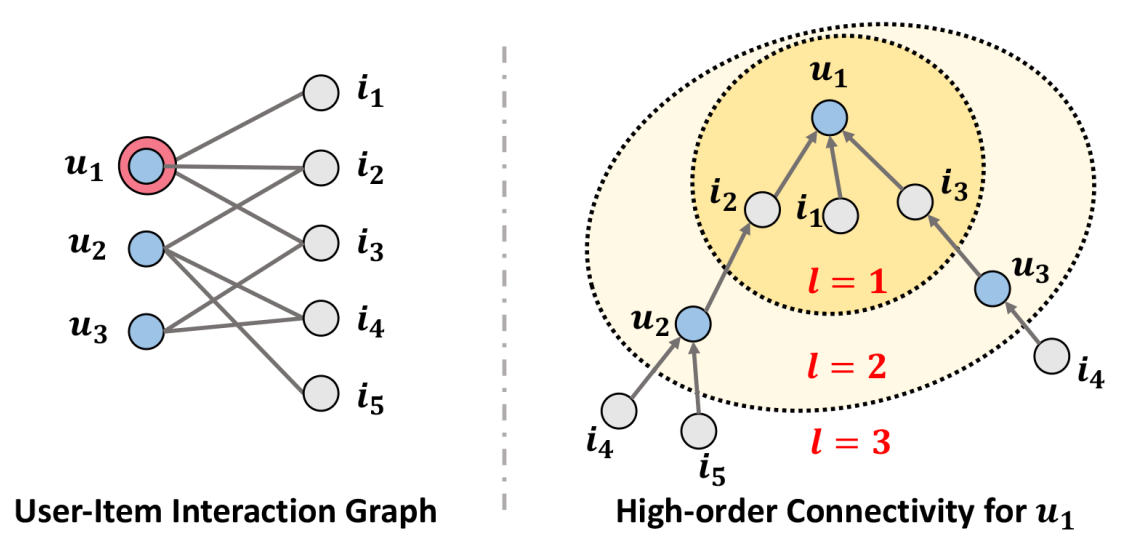

In [6]:
class NGCFLayer(nn.Module):
    def __init__(self, in_size, out_size, norm_dict, dropout):
        super(NGCFLayer, self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        #weights for different types of messages
        self.W1 = nn.Linear(in_size, out_size, bias = True)
        self.W2 = nn.Linear(in_size, out_size, bias = True)

        #leaky relu
        self.leaky_relu = nn.LeakyReLU(0.2)

        #dropout layer
        self.dropout = nn.Dropout(dropout)

        #initialization
        torch.nn.init.xavier_uniform_(self.W1.weight)
        torch.nn.init.constant_(self.W1.bias, 0)
        torch.nn.init.xavier_uniform_(self.W2.weight)
        torch.nn.init.constant_(self.W2.bias, 0)

        #norm
        self.norm_dict = norm_dict

    def forward(self, g, feat_dict):

        funcs = {} #message and reduce functions dict
        #for each type of edges, compute messages and reduce them all
        for srctype, etype, dsttype in g.canonical_etypes:
            if srctype == dsttype: #for self loops
                messages = self.W1(feat_dict[srctype])
                g.nodes[srctype].data[etype] = messages   #store in ndata
                funcs[(srctype, etype, dsttype)] = (fn.copy_u(etype, 'm'), fn.sum('m', 'h'))  #define message and reduce functions
            else:
                src, dst = g.edges(etype=(srctype, etype, dsttype))
                norm = self.norm_dict[(srctype, etype, dsttype)]
                messages = norm * (self.W1(feat_dict[srctype][src]) + self.W2(feat_dict[srctype][src]*feat_dict[dsttype][dst])) #compute messages
                g.edges[(srctype, etype, dsttype)].data[etype] = messages  #store in edata
                funcs[(srctype, etype, dsttype)] = (fn.copy_e(etype, 'm'), fn.sum('m', 'h'))  #define message and reduce functions

        g.multi_update_all(funcs, 'sum') #update all, reduce by first type-wisely then across different types
        feature_dict={}
        for ntype in g.ntypes:
            h = self.leaky_relu(g.nodes[ntype].data['h']) #leaky relu
            h = self.dropout(h) #dropout
            h = F.normalize(h,dim=1,p=2) #l2 normalize
            feature_dict[ntype] = h
        return feature_dict

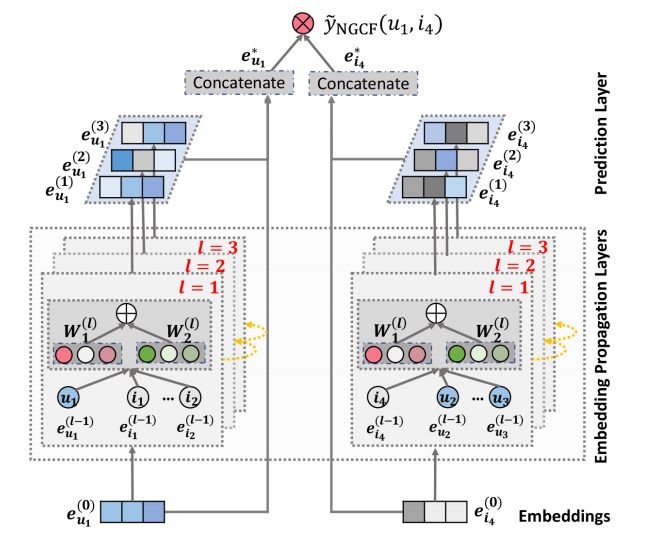

In [7]:
class NGCF(nn.Module):
    def __init__(self, g, in_size, layer_size, dropout, lmbd=1e-5):
        super(NGCF, self).__init__()
        self.lmbd = lmbd
        self.norm_dict = dict()
        for srctype, etype, dsttype in g.canonical_etypes:
            src, dst = g.edges(etype=(srctype, etype, dsttype))
            dst_degree = g.in_degrees(dst, etype=(srctype, etype, dsttype)).float() #obtain degrees
            src_degree = g.out_degrees(src, etype=(srctype, etype, dsttype)).float()
            norm = torch.pow(src_degree * dst_degree, -0.5).unsqueeze(1) #compute norm
            self.norm_dict[(srctype, etype, dsttype)] = norm

        self.layers = nn.ModuleList()
        self.layers.append(
            NGCFLayer(in_size, layer_size[0], self.norm_dict, dropout[0])
        )
        self.num_layers = len(layer_size)
        for i in range(self.num_layers-1):
            self.layers.append(
                NGCFLayer(layer_size[i], layer_size[i+1], self.norm_dict, dropout[i+1])
            )
        self.initializer = nn.init.xavier_uniform_

        #embeddings for different types of nodes
        self.feature_dict = nn.ParameterDict({
            ntype: nn.Parameter(self.initializer(torch.empty(g.num_nodes(ntype), in_size))) for ntype in g.ntypes
        })

    def create_bpr_loss(self, users, pos_items, neg_items):
        pos_scores = (users * pos_items).sum(1)
        neg_scores = (users * neg_items).sum(1)

        mf_loss = nn.LogSigmoid()(pos_scores - neg_scores).mean()
        mf_loss = -1 * mf_loss

        regularizer = (torch.norm(users) ** 2 + torch.norm(pos_items) ** 2 + torch.norm(neg_items) ** 2) / 2
        emb_loss = self.lmbd * regularizer / users.shape[0]

        return mf_loss + emb_loss, mf_loss, emb_loss

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, g,user_key, item_key, users, pos_items, neg_items):
        h_dict = {ntype : self.feature_dict[ntype] for ntype in g.ntypes}
        #obtain features of each layer and concatenate them all
        user_embeds = []
        item_embeds = []
        user_embeds.append(h_dict[user_key])
        item_embeds.append(h_dict[item_key])
        for layer in self.layers:
            h_dict = layer(g, h_dict)
            user_embeds.append(h_dict[user_key])
            item_embeds.append(h_dict[item_key])
        user_embd = torch.cat(user_embeds, 1)
        item_embd = torch.cat(item_embeds, 1)

        u_g_embeddings = user_embd[users, :]
        pos_i_g_embeddings = item_embd[pos_items, :]
        neg_i_g_embeddings = item_embd[neg_items, :]

        return u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings

### Batch testing function

In [8]:
cores = multiprocessing.cpu_count()

args = parse_args()
Ks = eval(args.Ks)

data_generator = Data(path=args.data_path + args.dataset, batch_size=args.batch_size)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size

def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(metrics.precision_at_k(r, K))
        recall.append(metrics.recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(metrics.ndcg_at_k(r, K))
        hit_ratio.append(metrics.hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}


def test_one_user(x):
    # user u's ratings for user u
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)


def test(model, g, users_to_test, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

    pool = multiprocessing.Pool(cores)

    u_batch_size = 5000
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1

    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size

        user_batch = test_users[start: end]

        if batch_test_flag:
            # batch-item test
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)

                u_g_embeddings, pos_i_g_embeddings, _ = model(g, 'user', 'item',user_batch, item_batch, [])
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            # all-item test
            item_batch = range(ITEM_NUM)
            u_g_embeddings, pos_i_g_embeddings, _ = model(g, 'user', 'item',user_batch, item_batch, [])
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

        user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision']/n_test_users
            result['recall'] += re['recall']/n_test_users
            result['ndcg'] += re['ndcg']/n_test_users
            result['hit_ratio'] += re['hit_ratio']/n_test_users
            result['auc'] += re['auc']/n_test_users


    assert count == n_test_users
    pool.close()
    return result

n_users=29858, n_items=40981
n_interactions=1027370
n_train=810128, n_test=217242, sparsity=0.00084


### Training

In [9]:
def main(args):
    # Step 1: Prepare graph data and device ================================================================= #
    if args.gpu >= 0 and torch.cuda.is_available():
        device = 'cuda:{}'.format(args.gpu)
    else:
        device = 'cpu'

    g=data_generator.g
    g=g.to(device)

    # Step 2: Create model and training components=========================================================== #
    model = NGCF(g, args.embed_size, args.layer_size, args.mess_dropout, args.regs[0]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Step 3: training epoches ============================================================================== #
    n_batch = data_generator.n_train // args.batch_size + 1
    t0 = time()
    cur_best_pre_0, stopping_step = 0, 0
    loss_loger, pre_loger, rec_loger, ndcg_loger, hit_loger = [], [], [], [], []
    for epoch in range(args.epoch):
        t1 = time()
        loss, mf_loss, emb_loss = 0., 0., 0.
        for idx in range(n_batch):
            users, pos_items, neg_items = data_generator.sample()
            u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings = model(g, 'user', 'item', users,
                                                                           pos_items,
                                                                           neg_items)

            batch_loss, batch_mf_loss, batch_emb_loss = model.create_bpr_loss(u_g_embeddings,
                                                                              pos_i_g_embeddings,
                                                                              neg_i_g_embeddings)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            loss += batch_loss
            mf_loss += batch_mf_loss
            emb_loss += batch_emb_loss
            

        if (epoch + 1) % 10 != 0:
            if args.verbose > 0 and epoch % args.verbose == 0:
                perf_str = 'Epoch %d [%.1fs]: train==[%.5f=%.5f + %.5f]' % (
                    epoch, time() - t1, loss, mf_loss, emb_loss)
                print(perf_str)
            continue #end the current epoch and move to the next epoch, let the following evaluation run every 10 epoches

        #evaluate the model every 10 epoches
        t2 = time()
        users_to_test = list(data_generator.test_set.keys())
        ret = test(model, g, users_to_test)
        t3 = time()

        loss_loger.append(loss)
        rec_loger.append(ret['recall'])
        pre_loger.append(ret['precision'])
        ndcg_loger.append(ret['ndcg'])
        hit_loger.append(ret['hit_ratio'])

        if args.verbose > 0:
            perf_str = 'Epoch %d [%.1fs + %.1fs]: train==[%.5f=%.5f + %.5f], recall=[%.5f, %.5f], ' \
                       'precision=[%.5f, %.5f], hit=[%.5f, %.5f], ndcg=[%.5f, %.5f]' % \
                       (epoch, t2 - t1, t3 - t2, loss, mf_loss, emb_loss, ret['recall'][0], ret['recall'][-1],
                        ret['precision'][0], ret['precision'][-1], ret['hit_ratio'][0], ret['hit_ratio'][-1],
                        ret['ndcg'][0], ret['ndcg'][-1])
            print(perf_str)

        cur_best_pre_0, stopping_step, should_stop = early_stopping(ret['recall'][0], cur_best_pre_0,
                                                                    stopping_step, expected_order='acc', flag_step=5)

        # early stop
        if should_stop == True:
            break

        if ret['recall'][0] == cur_best_pre_0 and args.save_flag == 1:
            torch.save(model.state_dict(), args.weights_path + args.model_name)
            print('save the weights in path: ', args.weights_path + args.model_name)

    recs = np.array(rec_loger)
    pres = np.array(pre_loger)
    ndcgs = np.array(ndcg_loger)
    hit = np.array(hit_loger)

    best_rec_0 = max(recs[:, 0])
    idx = list(recs[:, 0]).index(best_rec_0)

    final_perf = "Best Iter=[%d]@[%.1f]\trecall=[%s], precision=[%s], hit=[%s], ndcg=[%s]" % \
                 (idx, time() - t0, '\t'.join(['%.5f' % r for r in recs[idx]]),
                  '\t'.join(['%.5f' % r for r in pres[idx]]),
                  '\t'.join(['%.5f' % r for r in hit[idx]]),
                  '\t'.join(['%.5f' % r for r in ndcgs[idx]]))
    print(final_perf)

In [10]:
if not os.path.exists(args.weights_path):
    os.mkdir(args.weights_path)
args.mess_dropout = eval(args.mess_dropout)
args.layer_size = eval(args.layer_size)
args.regs = eval(args.regs)
print(args)
main(args)

Namespace(Ks='[20, 40]', batch_size=1024, data_path='/content/', dataset='gowalla', embed_size=64, epoch=400, gpu=1, layer_size=[64, 64, 64], lr=0.0001, mess_dropout=[0.1, 0.1, 0.1], model_name='NGCF.pkl', regs=[1e-05], report=0, save_flag=1, test_flag='part', verbose=1, weights_path='/content/')


DGLError: ignored